In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.3 MB/s eta 0:00:00


# Imports

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

SEED = 123

# Agents

In [ ]:
class n_SARSA:
    def __init__(self, n_states, n_actions):
        # setting parameters
        self.Q = np.zeros((n_states, n_actions))

        # hyperparameters to tune
        self.lrate = 0.15
        self.drate = 0.95
        print("[n-step SARSA AGENT SET]\n")

    def update(self, states, actions, rewards, tau, global_t, done):
        td_target = 0
        # for i in range(tau + 1, min(tau+n, global_t) + 1):
        for i in range(tau , min(tau+n, global_t) ):
            # td_target += np.power(self.drate, i - tau - 1 ) * rewards[i]
            td_target += np.power(self.drate, i - tau ) * rewards[i]

        if tau + n < global_t:
            q_vals_next = np.power(self.drate, n) * self.Q[states[tau+n], actions[tau+n]] * (1-done) # Q(s',a')
            td_target += q_vals_next

        # if done or tru:
        #     print("[DONE]", (1-done), td_target, tau)


        td_error = td_target - self.Q[states[tau], actions[tau]]
        self.Q[states[tau], actions[tau]] += self.lrate * td_error

        return self.Q[states[tau], actions[tau]]

class QLearning:
    def __init__(self, n_states, n_actions):
        # setting parameters
        self.Q = np.zeros((n_states, n_actions))

        # hyperparameters to tune
        self.lrate = 0.15
        self.drate = 0.95
        print("[QLearning AGENT SET]\n")

    def update(self, state, action, reward, next_state, done):
        # Qlearning algorithm: Q(s,a) := Q(s,a) + learning_rate * (reward + discount_rate * max_a' Q(s',a') - Q(s,a))
        td_target = reward + self.drate * (1 - done) * np.max(self.Q[next_state, :])
        td_error = td_target - self.Q[state, action]
        self.Q[state, action] += self.lrate * td_error

        return self.Q[state, action]

class n_QLearning:
    def __init__(self, n_states, n_actions):
        # setting parameters
        self.Q = np.zeros((n_states, n_actions))

        # hyperparameters to tune
        self.lrate = 0.15
        self.drate = 0.95
        print("[n-step QLearning AGENT SET]\n")

    def update(self, states, actions, rewards, tau, global_t, done):
        td_target = 0
        for i in range(tau , min(tau+n, global_t) ):
            td_target += np.power(self.drate, i - tau ) * rewards[i]

        if tau + n < global_t:
            q_vals_next = np.power(self.drate, n) * self.Q[states[tau+n]][ np.argmax(self.Q[states[tau+n]]) ] * (1-done)
            td_target += q_vals_next

        td_error = td_target - self.Q[states[tau], actions[tau]]
        self.Q[states[tau], actions[tau]] += self.lrate * td_error

        return self.Q[states[tau], actions[tau]]

# Environment

In [ ]:
GAME = "Taxi-v3"
env = gym.make(GAME, max_episode_steps=300)
# env = gym.make(GAME, max_episode_steps=55)
np.random.seed(SEED)  # Make plots reproducible

n_states = env.observation_space.n
n_actions = env.action_space.n

print(n_states, n_actions)

# epsilon = 1.0     # probability that our agent will explore
epsilon = .2     # probability that our agent will explore
decay = 0.0075 # of epsilon

# Choose an action using epsilon-greedy strategy
def choose_action(agent, state):

    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(agent.Q[state, :])  # Exploit

# epsilon = np.exp(-decay*episode)

def evaluate_policy(env, Q, episodes=10):
    total_rewards = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = np.argmax(Q[state])  # Choose the best action based on learned Q-values

            state, reward, done, truncated, _ = env.step(action)
            total_rewards += reward
            if truncated:
                break

    average_reward = total_rewards / episodes

    return average_reward

500 6


In [ ]:
# toPlot = [np.exp(-decay * i) for i in range(300)]

# plt.plot(toPlot), toPlot[-1]

# Training

## $n$-step SARSA

In [ ]:
EPISODES = 500
RUNS = 10

average_cumulative_reward = 0.0
runs_list = np.zeros(shape=(RUNS, EPISODES))
n = 4  # n-step SARSA


for i in range(RUNS):
    agent = n_SARSA(n_states, n_actions)
    avg_cumulative_list = []
    print(f"Agent: {i+1}")

    for ep in range(EPISODES):
        state = env.reset()[0]
        action = choose_action(agent, state)
        states = [state]
        actions = [action]
        # rewards = [0.]
        rewards = []

        done = False
        cumulative_reward = 0.0
        T = float('inf')
        t = 0

        while True:
            if t < T:
                next_state, reward, done, truncated, info = env.step(action)  # Take action
                # reward -= 0.15
                rewards.append(reward)
                states.append(next_state)

                if done or truncated:
                    T = t + 1
                    # print("\t [DONE]", tau, t, T)
                else:
                    next_action = choose_action(agent, next_state) # Choose next action
                    actions.append(next_action)
            tau = t - n + 1 # Time whose state's estimate is being updated, state to be updated
            if tau >= 0:
                agent.update(states, actions, rewards, tau, T, done)

                # Update statistics
                cumulative_reward += rewards[tau] # np.mean(rewards)
            state, action = next_state, next_action.copy()
            if tau == T - 1:
                break
            t += 1
        # Per-episode statistics
        average_cumulative_reward *= 0.95
        average_cumulative_reward += 0.05 * cumulative_reward
        avg_cumulative_list.append(average_cumulative_reward)

        # epsilon = np.exp(-decay*ep)

        if ep % 50 == 0:
            print(f"Episode: {ep} \tAvg cumul reward: {average_cumulative_reward:.4f}")

    print()
    runs_list[i] = np.array(avg_cumulative_list)

avg_ql = evaluate_policy(env, agent.Q, 10)
print(f"\n- Avg reward over 10 episodes: {avg_ql}\n")

[n-step SARSA AGENT SET]

Agent: 1
Episode: 0 	Avg cumul reward: -37.9500
Episode: 50 	Avg cumul reward: -762.7381
Episode: 100 	Avg cumul reward: -479.2737
Episode: 150 	Avg cumul reward: -372.0423
Episode: 200 	Avg cumul reward: -270.9240
Episode: 250 	Avg cumul reward: -227.4611
Episode: 300 	Avg cumul reward: -111.7199
Episode: 350 	Avg cumul reward: -49.7368
Episode: 400 	Avg cumul reward: -32.0198
Episode: 450 	Avg cumul reward: -21.7253

[n-step SARSA AGENT SET]

Agent: 2
Episode: 0 	Avg cumul reward: -74.9696
Episode: 50 	Avg cumul reward: -732.4413
Episode: 100 	Avg cumul reward: -496.7207
Episode: 150 	Avg cumul reward: -357.0271
Episode: 200 	Avg cumul reward: -220.9322
Episode: 250 	Avg cumul reward: -100.0677
Episode: 300 	Avg cumul reward: -79.6758
Episode: 350 	Avg cumul reward: -32.3758
Episode: 400 	Avg cumul reward: -17.8703
Episode: 450 	Avg cumul reward: -25.8299

[n-step SARSA AGENT SET]

Agent: 3
Episode: 0 	Avg cumul reward: -94.1027
Episode: 50 	Avg cumul reward

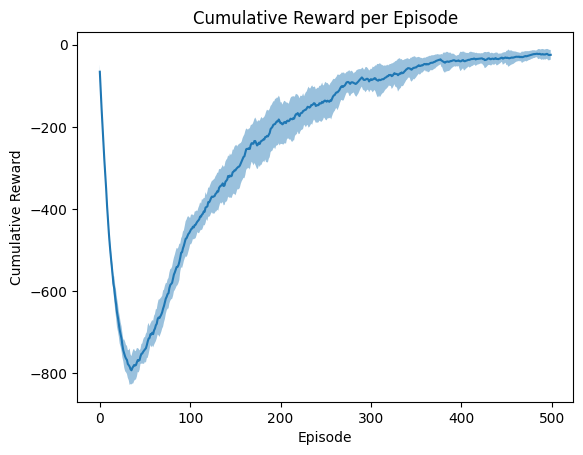

In [ ]:
means_Nsarsa = np.mean(runs_list, axis=0)
stds_Nsarsa = np.std(runs_list, axis=0)

plt.plot(means_Nsarsa)
plt.fill_between(range(EPISODES), means_Nsarsa-stds_Nsarsa, means_Nsarsa+stds_Nsarsa, alpha=.45)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward');

## Q Learning

In [ ]:
EPISODES = 500
RUNS= 10
average_cumulative_reward = 0.0
runs_list = np.zeros(shape=(RUNS, EPISODES))
avg_list = np.zeros(shape=(RUNS))

for i in range(RUNS):
    agent = QLearning(n_states, n_actions)
    avg_cumulative_list = []
    print(f"Agent: {i+1}")

    for ep in range(EPISODES):
        state = env.reset()[0]
        done = False
        cumulative_reward = 0.0

        while not done:
            action = choose_action(agent, state) # Choose  action
            next_state, reward, done, truncated, info = env.step(action)  # Take action

            agent.update(state, action, reward, next_state, done)
            # Update statistics
            cumulative_reward += reward
            state = next_state
            if truncated: # cut-off to 300 steps
                break
        # Per-episode statistics
        average_cumulative_reward *= 0.95
        average_cumulative_reward += 0.05 * cumulative_reward
        avg_cumulative_list.append(average_cumulative_reward)

        # epsilon = np.exp(-decay*ep)

        if ep % 50 == 0:
            print(f"Episode: {ep} \tAvg cumul reward: {average_cumulative_reward:.4f}")

    runs_list[i] = np.array(avg_cumulative_list)
    print()
# avg_list[i] = avg_ql
avg_ql = evaluate_policy(env, agent.Q, 10)
print(f"\n- Avg reward over 10 episodes: {avg_ql}\n")

[QLearning AGENT SET]

Agent: 1
Episode: 0 	Avg cumul reward: -42.4500
Episode: 50 	Avg cumul reward: -425.4441
Episode: 100 	Avg cumul reward: -372.9738
Episode: 150 	Avg cumul reward: -271.0526
Episode: 200 	Avg cumul reward: -176.7536
Episode: 250 	Avg cumul reward: -171.0919
Episode: 300 	Avg cumul reward: -93.4599
Episode: 350 	Avg cumul reward: -84.3136
Episode: 400 	Avg cumul reward: -67.3345
Episode: 450 	Avg cumul reward: -63.6869

[QLearning AGENT SET]

Agent: 2
Episode: 0 	Avg cumul reward: -80.5047
Episode: 50 	Avg cumul reward: -446.9160
Episode: 100 	Avg cumul reward: -294.1332
Episode: 150 	Avg cumul reward: -259.3163
Episode: 200 	Avg cumul reward: -219.8038
Episode: 250 	Avg cumul reward: -148.9964
Episode: 300 	Avg cumul reward: -83.9503
Episode: 350 	Avg cumul reward: -83.4321
Episode: 400 	Avg cumul reward: -71.6746
Episode: 450 	Avg cumul reward: -42.3568

[QLearning AGENT SET]

Agent: 3
Episode: 0 	Avg cumul reward: -85.5957
Episode: 50 	Avg cumul reward: -428.654

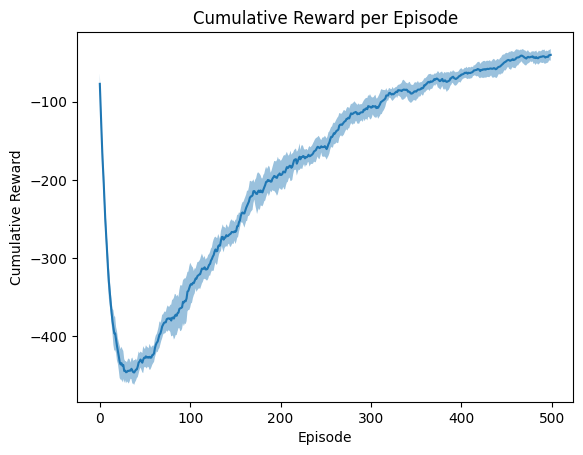

In [ ]:
means = np.mean(runs_list, axis=0)
stds = np.std(runs_list, axis=0)

plt.plot(means)
plt.fill_between(range(EPISODES), means-stds,means+stds,alpha=.45)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward');

## $n$-step Q Learning

In [ ]:
EPISODES = 500
RUNS = 10

average_cumulative_reward = 0.0
runs_list = np.zeros(shape=(RUNS, EPISODES))
n = 4  # n-step QL


for i in range(RUNS):
    agent = n_QLearning(n_states, n_actions)
    avg_cumulative_list = []
    print(f"Agent: {i+1}")

    for ep in range(EPISODES):
        state = env.reset()[0]

        states = [state]
        actions = []
        rewards = []

        done = False
        cumulative_reward = 0.0
        T = float('inf')
        t = 0

        while True:
            if t < T:
                action = choose_action(agent, state)
                next_state, reward, done, truncated, info = env.step(action)  # Take action
                # reward -= 0.15
                rewards.append(reward)
                states.append(next_state)
                actions.append(action)

                if done or truncated:
                    T = t + 1

            tau = t - n + 1 # Time whose state's estimate is being updated, state to be updated
            if tau >= 0:
                agent.update(states, actions, rewards, tau, T, done)

                # Update statistics
                cumulative_reward += rewards[tau] # np.mean(rewards)

            state = next_state

            if tau == T - 1:
                break
            t += 1
        # Per-episode statistics
        average_cumulative_reward *= 0.95
        average_cumulative_reward += 0.05 * cumulative_reward
        avg_cumulative_list.append(average_cumulative_reward)

        # epsilon = np.exp(-decay*ep)

        if ep % 50 == 0:
            print(f"Episode: {ep} \tAvg cumul reward: {average_cumulative_reward:.4f}, \t {cumulative_reward}")

    print()
    runs_list[i] = np.array(avg_cumulative_list)

avg_ql = evaluate_policy(env, agent.Q, 10)
print(f"\n- Avg reward over 10 episodes: {avg_ql}\n")

[n-step QLearning AGENT SET]

Agent: 1
Episode: 0 	Avg cumul reward: -46.5000, 	 -930.0
Episode: 50 	Avg cumul reward: -611.4383, 	 -57.0
Episode: 100 	Avg cumul reward: -418.3611, 	 -570.0
Episode: 150 	Avg cumul reward: -248.6877, 	 -588.0
Episode: 200 	Avg cumul reward: -152.8439, 	 5.0
Episode: 250 	Avg cumul reward: -70.4431, 	 -444.0
Episode: 300 	Avg cumul reward: -55.9063, 	 2.0
Episode: 350 	Avg cumul reward: -20.1394, 	 -47.0
Episode: 400 	Avg cumul reward: -25.9514, 	 -13.0
Episode: 450 	Avg cumul reward: -22.1635, 	 -46.0

[n-step QLearning AGENT SET]

Agent: 2
Episode: 0 	Avg cumul reward: -62.2509, 	 -1047.0
Episode: 50 	Avg cumul reward: -692.4235, 	 -912.0
Episode: 100 	Avg cumul reward: -506.8430, 	 -226.0
Episode: 150 	Avg cumul reward: -248.8024, 	 -489.0
Episode: 200 	Avg cumul reward: -174.0881, 	 -4.0
Episode: 250 	Avg cumul reward: -133.7217, 	 -73.0
Episode: 300 	Avg cumul reward: -67.3075, 	 12.0
Episode: 350 	Avg cumul reward: -36.3953, 	 10.0
Episode: 400 	Av

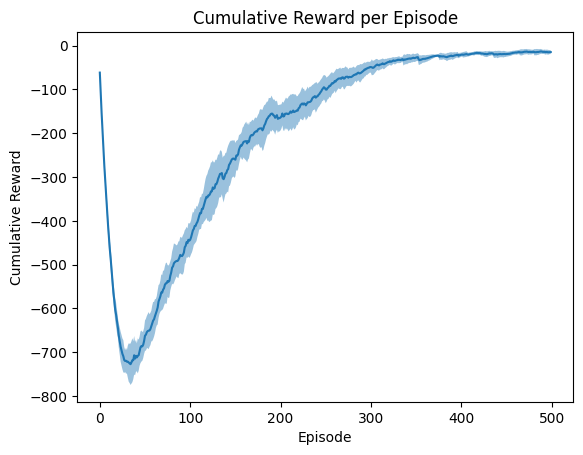

In [ ]:
means_Nql = np.mean(runs_list, axis=0)
stds_Nql = np.std(runs_list, axis=0)

plt.plot(means_Nql)
plt.fill_between(range(EPISODES), means_Nql-stds_Nql,means_Nql+stds_Nql,alpha=.45)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward');

# Together

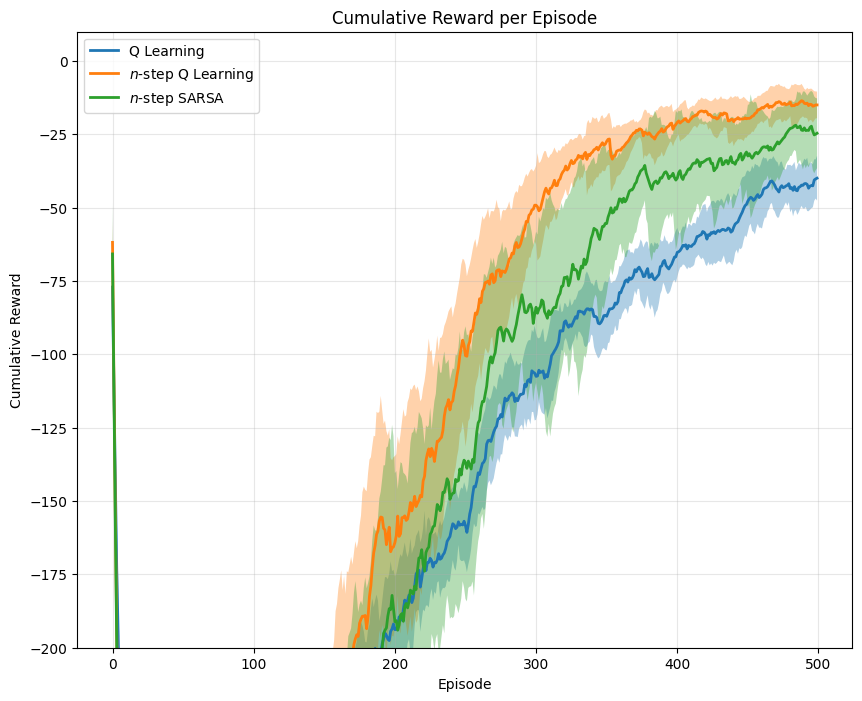

In [ ]:
plt.figure(figsize=(10, 8))

plt.plot(means, label='Q Learning', linewidth=2)
plt.plot(means_Nql, label='$n$-step Q Learning', linewidth=2)
plt.plot(means_Nsarsa, label="$n$-step SARSA", linewidth=2)

plt.fill_between(range(EPISODES), means-stds,means+stds,alpha=.35)
plt.fill_between(range(EPISODES), means_Nql-stds_Nql,means_Nql+stds_Nql,alpha=.35)
plt.fill_between(range(EPISODES), means_Nsarsa-stds_Nsarsa, means_Nsarsa+stds_Nsarsa, alpha=.35)

plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward');
plt.grid(True, alpha=.3)
plt.ylim(-200, 10)
plt.legend();